We got the raw data from Wolfel et al paper on SARS-CoV-2 shedding in 9 patients (but they didn't share the individual time course data, everything is in aggregate).

We want to plot the clinical data with the MLE/MCMC shedding function results from the other Jupyter notebook and make a nice high res figure.

We have done the MLE and MCMC for 1x, 6x, and 24x cases based on CDC paper on unreported cases.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../data/deer_island/2020-05-22_wolfel_stool_shedding_data.csv')

In [3]:
ave_shedding = df.groupby(['Day_postSymptomONSET']).mean().reset_index()

In [7]:
ave_shedding['SD'] = df.groupby(['Day_postSymptomONSET']).std().reset_index(drop=True)
ave_shedding['min'] = df.groupby(['Day_postSymptomONSET']).min().reset_index(drop=True)
ave_shedding['max'] = df.groupby(['Day_postSymptomONSET']).max().reset_index(drop=True)

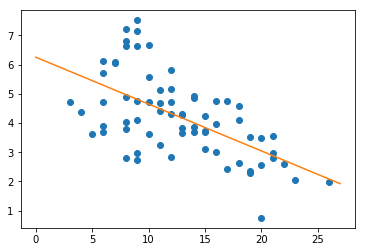

In [5]:
## plot all points and fit a line

plt.plot(df['Day_postSymptomONSET'], df['Mean_LOG10_RNA_g_Stool'], 'o')

reg = LinearRegression().fit(np.array(df['Day_postSymptomONSET']).reshape(-1,1), np.array(df['Mean_LOG10_RNA_g_Stool']))
plt.plot(np.linspace(0,27, 50), reg.predict(np.linspace(0,27,50).reshape(-1,1)))

In [12]:
# constants
ww_vol = 1.36e12 # average ww volume at deer island
offset = 4 # 4 days time lag between infection and reporting
stool_mass = 200 #200 g stool

In [13]:
def plot_fancy(accepted_df, accepted_6x, accepted_24x, best_abc, best_abc_6x, best_abc_24x, linear_path, log_path):
    # read in the accepted MCMC traces and best params from the other notebook
    accepted_df = pd.read_csv(accepted_df)
    accepted_6x = pd.read_csv(accepted_6x)
    accepted_24x = pd.read_csv(accepted_24x)
    best_abc = best_abc
    best_abc_6x = best_abc_6x
    best_abc_24x = best_abc_24x

    # get 100 random accepted mcmc traces
    random_100 = accepted_df.sample(n=100)
    random_100_6x = accepted_6x.sample(n=100)
    random_100_24x = accepted_24x.sample(n=100)

    # plot clinical and wastewater shedding
    # clinical data regression
    clin_x = np.linspace(2.5,27,50)
    clin_pred = reg.predict(clin_x.reshape(-1,1)) + np.log10(stool_mass) # clinical shedding (copies/g stool) * 200 g stool, multiplication in linear space = addition in log space

    # plotting
    fig, ax = plt.subplots(figsize=(7,6))

    # make a smoother graph by sampling more than once per day
    samples = np.arange(0.0, 1, 1/30/8)

    for _, row in random_100.iterrows():
        test_params = row.values
        test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1]) * ww_vol
        plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

    # plot best beta
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
    best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1]) * ww_vol
    plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

    # 6x
    for _, row in random_100_6x.iterrows():
        test_params = row.values
        test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1]) * ww_vol
        plt.plot(samples, test_smooth, color='lightcoral', alpha=0.2)

    # plot best beta 6x
    plt.plot(samples, test_smooth, color='lightcoral', alpha=0.15, label='100 accepted MCMC samples')
    best_beta_smooth = best_abc_6x[2] * beta.pdf(samples, best_abc_6x[0], best_abc_6x[1]) * ww_vol
    plt.plot(samples, best_beta_smooth, color='red', zorder=201, label='Maximum Likelihood Estimate')

    # 24x
    for _, row in random_100_24x.iterrows():
        test_params = row.values
        test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1]) * ww_vol
        plt.plot(samples, test_smooth, color='plum', alpha=0.2)

    # plot best beta 24x
    plt.plot(samples, test_smooth, color='plum', alpha=0.15, label='100 accepted MCMC samples')
    best_beta_smooth = best_abc_24x[2] * beta.pdf(samples, best_abc_24x[0], best_abc_24x[1]) * ww_vol
    plt.plot(samples, best_beta_smooth, color='purple', zorder=201, label='Maximum Likelihood Estimate')

    # plot clinical
    plt.plot((clin_x+offset)/30, clin_pred)
    plt.plot((df['Day_postSymptomONSET']+offset)/30, df['Mean_LOG10_RNA_g_Stool']+np.log10(200),
             'o', color='tab:orange', alpha=0.7)

    # relabel x as day 0 to day 30
    plt.xticks(samples[::16], np.arange(0,31,2), fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Viral shedding (copies/day)', fontsize=22)
    plt.xlabel('Days of shedding', fontsize=22)
    ax.yaxis.offsetText.set_fontsize(18)

    plt.tight_layout()
    # plt.savefig(linear_path, format='pdf', dpi=300)


    # plotting log scale
    fig, ax = plt.subplots(figsize=(7,6))

    # make a smoother graph by sampling more than once per day
    samples = np.arange(0.0, 1, 1/30/8)

    # 1x
    for _, row in random_100.iterrows():
        test_params = row.values
        test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1]) * ww_vol

        # fix beta=0 to show up as 0 in log
        log_beta = np.log10(test_smooth)
        log_beta[~np.isfinite(log_beta)] = 0

        plt.plot(samples, log_beta, color='tab:blue', alpha=0.2)

    # plot best beta
    best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1]) * ww_vol
    # fix beta=0 to show up as 0 in log
    log_best_beta = np.log10(best_beta_smooth)
    log_best_beta[~np.isfinite(log_best_beta)] = 0
    plt.plot(samples, log_best_beta, color='black', zorder=101, label='MLE shedding (1x cases)')
    plt.plot(samples, log_beta, color='tab:blue', alpha=0.5, label='MCMC shedding (1x cases)')

    # 6x
    for _, row in random_100_6x.iterrows():
        test_params = row.values
        test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1]) * ww_vol

        # fix beta=0 to show up as 0 in log
        log_beta = np.log10(test_smooth)
        log_beta[~np.isfinite(log_beta)] = 0

        plt.plot(samples, log_beta, color='lightcoral', alpha=0.2)

    # plot best beta
    best_beta_smooth = best_abc_6x[2] * beta.pdf(samples, best_abc_6x[0], best_abc_6x[1]) * ww_vol
    # fix beta=0 to show up as 0 in log
    log_best_beta = np.log10(best_beta_smooth)
    log_best_beta[~np.isfinite(log_best_beta)] = 0
    plt.plot(samples, log_best_beta, color='red', zorder=201, label='MLE shedding (6x cases)')
    plt.plot(samples, log_beta, color='lightcoral', alpha=0.5, label='MCMC shedding (6x cases)')

    # 24x
    for _, row in random_100_24x.iterrows():
        test_params = row.values
        test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1]) * ww_vol

        # fix beta=0 to show up as 0 in log
        log_beta = np.log10(test_smooth)
        log_beta[~np.isfinite(log_beta)] = 0

        plt.plot(samples, log_beta, color='plum', alpha=0.2)

    # plot best beta
    best_beta_smooth = best_abc_24x[2] * beta.pdf(samples, best_abc_24x[0], best_abc_24x[1]) * ww_vol
    # fix beta=0 to show up as 0 in log
    log_best_beta = np.log10(best_beta_smooth)
    log_best_beta[~np.isfinite(log_best_beta)] = 0
    plt.plot(samples, log_best_beta, color='purple', zorder=301, label='MLE shedding (24x cases)')
    plt.plot(samples, log_beta, color='plum', alpha=0.5, label='MCMC shedding (24x cases)')

    # plot clinical
    plt.plot((df['Day_postSymptomONSET']+offset)/30, df['Mean_LOG10_RNA_g_Stool']+np.log10(200),
             'o', color='tab:orange', label='Clinical shedding', alpha=0.7, zorder=102)
    plt.plot((clin_x+offset)/30, clin_pred, color='tab:orange', label='Clinical shedding fit', zorder=103)

    # relabel x as day 0 to day 30
    plt.xticks(samples[::16], np.arange(0,33,2), fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Log10 Copies/day', fontsize=22)
    plt.xlabel('Days of shedding', fontsize=22)
    plt.ylim(2,13)
    ax.yaxis.offsetText.set_fontsize(18)
    plt.legend(fontsize=13)
    plt.tight_layout()
    # plt.savefig(log_path, format='pdf', dpi=300)
    
    return

## AD alone

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


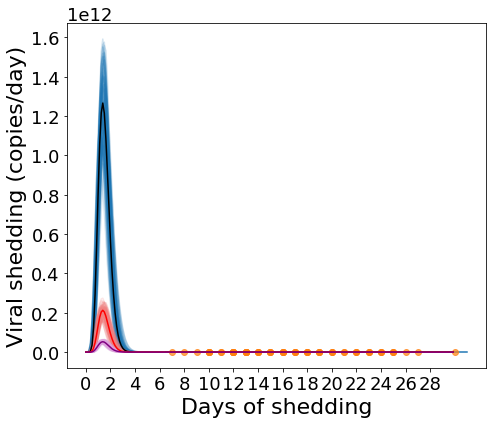

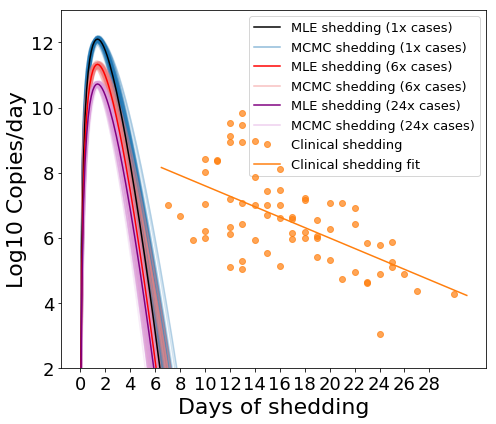

In [14]:
# Read in the MCMC results and get the best params from the other notebook
accepted_df = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AD_alone_tau4.csv'
accepted_6x = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AD_alone_tau4_6x_cases.csv'
accepted_24x = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AD_alone_tau4_24x_cases.csv'
best_abc = (10.379535961073248, 197.00652708376086, 0.03413144574242055)
best_abc_6x = (10.507656138860836, 199.55389600168357, 0.005701021033668142)
best_abc_24x = (10.439633497344587, 198.20188031536335, 0.0014235853181817303)

plot_fancy(accepted_df, accepted_6x, accepted_24x, best_abc, best_abc_6x, best_abc_24x,
          linear_path = '../figures/stoten_revision/2021-08-04_AD_alone_tau4_inferred_shedding.pdf',
          log_path = '../figures/stoten_revision/2021-08-04_AD_alone_tau4_inferred_shedding_log.pdf')

## AB alone

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


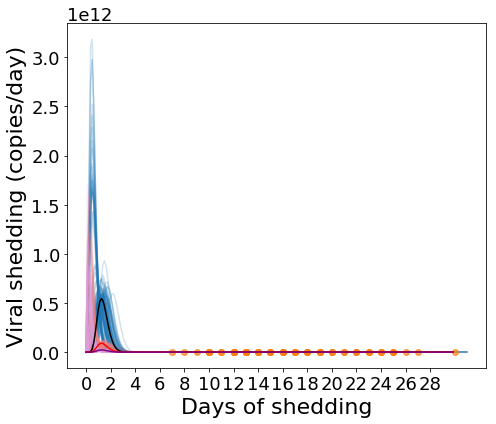

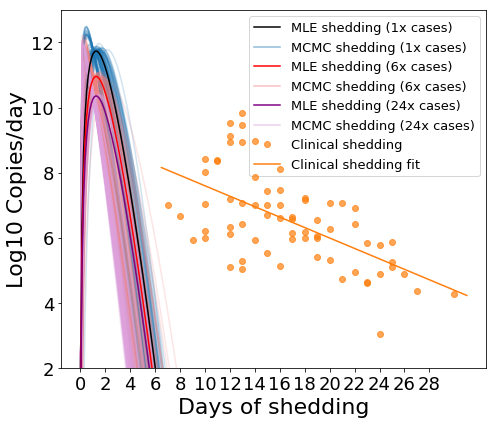

In [15]:
# Read in the MCMC results and get the best params from the other notebook
accepted_df = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AB_alone.csv'
accepted_6x = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AB_alone_6x_cases.csv'
accepted_24x = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AB_alone_24x_cases.csv'
best_abc = (9.757025099928327, 200.89016414287826, 0.014016077280861138)
best_abc_6x = (9.756251119254971, 200.87616534560547, 0.002335977844506277)
best_abc_24x = (9.778824067252943, 201.3137212098564, 0.0005841633582241804)

plot_fancy(accepted_df, accepted_6x, accepted_24x, best_abc, best_abc_6x, best_abc_24x,
          linear_path = '../figures/stoten_revision/2021-08-04_AB_alone_tau4_inferred_shedding.pdf',
          log_path = '../figures/stoten_revision/2021-08-04_AB_alone_tau4_inferred_shedding_log.pdf')

## nonscaled ave

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


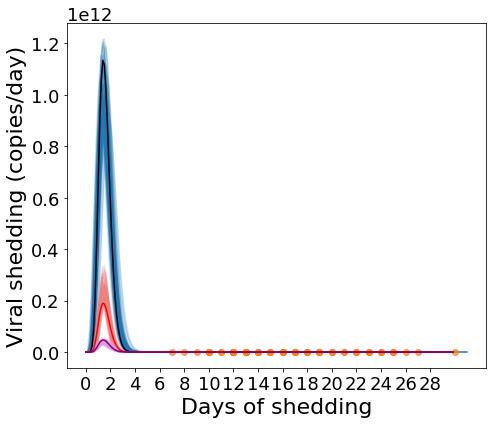

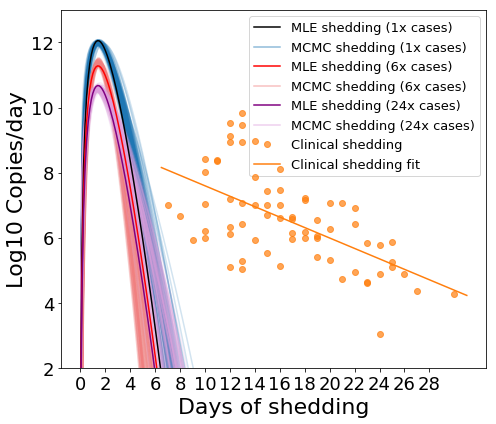

In [16]:
# how to combine this with the beta function??
accepted_df = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_ave.csv'
accepted_6x = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_ave_6x_cases.csv'
accepted_24x = '../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_ave_24x_cases.csv'
best_abc = (10.736122057797292, 197.61942367641294, 0.03107246888001779)
best_abc_6x = (10.828762193808984, 199.4800377906688, 0.00518723480248113)
best_abc_24x = (10.747687278224046, 197.8518127157473, 0.0012949462138592352)

plot_fancy(accepted_df, accepted_6x, accepted_24x, best_abc, best_abc_6x, best_abc_24x,
          linear_path = '../figures/stoten_revision/2021-08-04_nonscaled_ave_tau4_inferred_shedding.pdf',
          log_path = '../figures/stoten_revision/2021-08-04_nonscaled_ave_tau4_inferred_shedding_log.pdf')